In [17]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms

%pip install torchmetrics
from torchmetrics.functional import accuracy, precision, recall, f1_score
from PIL import Image
import matplotlib.pyplot as plt
%pip install torchviz
from torchviz import make_dot


Note: you may need to restart the kernel to use updated packages.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4132 sha256=4b30fafb8fb800b89db8b9a2da4e7859322de3c0153c60935f3ff0d73f6f0777
  Stored in directory: /home/adarsh/.cache/pip/wheels/98/f2/3d/290537e0ff7f67aaa647847a10fb5ee5eca305b3c41a774523
Successfully built torchviz
Note: you may need to restart the kernel to use updated packages.


In [21]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Hyperparameters

In [22]:
epoch = 50
batch_size = 32
num_workers = 2
shuffle = True
learning_rate = 0.005
train_size = 50000
val_size = 10000
test_size = 10000

# Custom Model

In [23]:
class CustomModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Conv2d(1, 32, 5, padding="same")
        self.batch_norm1 = nn.BatchNorm2d(32)

        self.layer2 = nn.Conv2d(32, 64, 5, padding="same")
        self.batch_norm2 = nn.BatchNorm2d(64)

        self.layer3 = nn.Linear(3136, 512)
        self.batch_norm3 = nn.BatchNorm1d(512)

        self.layer4 = nn.Linear(512, 128)
        self.batch_norm4 = nn.BatchNorm1d(128)

        self.layer5 = nn.Linear(128, 32)
        self.batch_norm5 = nn.BatchNorm1d(32)

        self.output = nn.Linear(32, 10)

    def forward(self, x):
        x = F.max_pool2d(
            F.relu(self.batch_norm1(self.layer1(x))), kernel_size=2, stride=2
        )
        x = F.max_pool2d(
            F.relu(self.batch_norm2(self.layer2(x))), kernel_size=2, stride=2
        )
        x = x.view(-1, 3136)
        x = F.relu(self.batch_norm3(self.layer3(x)))
        x = F.relu(self.batch_norm4(self.layer4(x)))
        x = F.relu(self.batch_norm5(self.layer5(x)))
        x = self.output(x)
        return x

In [15]:
dataset = MNIST(root="", download=True)
# Random_split can take both subclass of Dataset or np.ndarray etc anything.
train_dataset, val_dataset = random_split(dataset, [50000, 10000])

test_dataset = MNIST(root="", train=False, download=True)

In [16]:
# Custom collate is required here as we have images as PIL.Image.Image object.
# These can't be directly converted to tensor, We have to use do it via np.ndarray
# Tensor returned here are mounted on GPU (assuming VRAM will have enough to store the data in gpu)
def custom_collate(
    batch,
):
    """This is custom collate function"""
    imgs = torch.tensor(
        np.array([[idv_data[0]] for idv_data in batch]), dtype=torch.float32
    )
    label = torch.tensor([idv_data[1] for idv_data in batch], dtype=torch.int64)
    return imgs, label

# Training dataloader

In [100]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=shuffle,
    num_workers=num_workers,
    collate_fn=custom_collate,
    pin_memory=True,
)

# Training dataloader for evaluation metrices(without batching)

In [101]:
train_eval_imgs = torch.tensor(
    np.array([[train_dataset[i][0]] for i in range(len(train_dataset))]),
    dtype=torch.float32,
    device=device,
)
train_eval_labels = torch.tensor(
    [train_dataset[i][1] for i in range(len(train_dataset))],
    dtype=torch.int64,
    device=device,
)
train_eval_dataloader = (train_eval_imgs, train_eval_labels)
train_eval_dataloader[0].shape

torch.Size([50000, 1, 28, 28])

# Validation dataloader for evaluation metrices(without batching)

In [102]:
val_imgs = torch.tensor(
    np.array([[val_dataset[i][0]] for i in range(len(val_dataset))]),
    dtype=torch.float32,
    device=device,
)
val_labels = torch.tensor(
    [val_dataset[i][1] for i in range(len(val_dataset))],
    dtype=torch.int64,
    device=device,
)
val_dataloader = (val_imgs, val_labels)

# Evaluation Class

In [25]:
class Metrices:
    def __init__(self):
        self.accuracy = 0
        self.recall = 0
        self.f1_score = 0
        self.precision = 0

        self.accuracy_list = []
        self.precision_list = []
        self.f1_score_list = []
        self.recall_list = []

    def __call__(self, y_pred, y_true):
        # As here each class label has equal weightage so type of average taken is macro.
        self.accuracy = accuracy(
            y_pred, y_true, task="multiclass", num_classes=10, average="macro"
        ).item()
        self.precision = precision(
            y_pred, y_true, task="multiclass", num_classes=10, average="macro"
        ).item()
        self.f1_score = f1_score(
            y_pred, y_true, task="multiclass", num_classes=10, average="macro"
        ).item()
        self.recall = recall(
            y_pred, y_true, task="multiclass", num_classes=10, average="macro"
        ).item()

        self.accuracy_list.append(self.accuracy)
        self.precision_list.append(self.precision)
        self.f1_score_list.append(self.f1_score)
        self.recall_list.append(self.recall)

In [26]:
no_of_pixels = 784
train_metrices = Metrices()
val_metrices = Metrices()

criterion = nn.CrossEntropyLoss()
model = CustomModel()
model.to(device)
optimizer = torch.optim.Adam(model.parameters())

# Training loop

In [105]:
for cur_epoch in range(epoch):
    for batch_x, batch_y_true in train_dataloader:
        model.train()
        batch_x = batch_x.to(device)
        batch_y_true = batch_y_true.to(device)
        batch_y_pred = model(batch_x)
        # batch_y_true is 1D and batch_y_pred 2D shape(batch_size,10).
        loss = criterion(
            batch_y_pred,
            batch_y_true,
        )
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print(f"\nEpoch [{cur_epoch+1}/{epoch}], Loss: {loss}")

    with torch.no_grad():
        model.eval()
        train_eval_x = train_eval_dataloader[0].to(device)
        train_eval_y_pred = model(train_eval_x)
        train_eval_y_true = train_eval_dataloader[1].to(device)
        train_metrices(train_eval_y_pred, train_eval_y_true)
        print("Train metrices:")
        print(
            f"Accuracy: {train_metrices.accuracy:.5f}, Precision: {train_metrices.precision:.5f}, Recall: {train_metrices.recall:.5f}, F1_Score: {train_metrices.f1_score:.5f}"
        )

        val_x = val_dataloader[0].to(device)
        val_y_pred = model(val_x)
        val_y_true = val_dataloader[1].to(device)
        val_metrices(val_y_pred, val_y_true)
        print("Validation metrices:")
        print(
            f"Accuracy: {val_metrices.accuracy:.5f}, Precision: {val_metrices.precision:.5f}, Recall: {val_metrices.recall:.5f}, F1_Score: {val_metrices.f1_score:.5f}"
        )


Epoch [1/50], Loss: 0.03885207697749138
Train metrices:
Accuracy: 0.98806, Precision: 0.98807, Recall: 0.98806, F1_Score: 0.98805
Validation metrices:
Accuracy: 0.98444, Precision: 0.98439, Recall: 0.98444, F1_Score: 0.98439

Epoch [2/50], Loss: 0.05000881478190422
Train metrices:
Accuracy: 0.99320, Precision: 0.99321, Recall: 0.99320, F1_Score: 0.99320
Validation metrices:
Accuracy: 0.98964, Precision: 0.98963, Recall: 0.98964, F1_Score: 0.98963

Epoch [3/50], Loss: 0.08111929893493652
Train metrices:
Accuracy: 0.99508, Precision: 0.99509, Recall: 0.99508, F1_Score: 0.99508
Validation metrices:
Accuracy: 0.99146, Precision: 0.99159, Recall: 0.99146, F1_Score: 0.99152

Epoch [4/50], Loss: 0.026793573051691055
Train metrices:
Accuracy: 0.99495, Precision: 0.99496, Recall: 0.99495, F1_Score: 0.99494
Validation metrices:
Accuracy: 0.99001, Precision: 0.99004, Recall: 0.99001, F1_Score: 0.99001

Epoch [5/50], Loss: 0.0008314319420605898
Train metrices:
Accuracy: 0.99685, Precision: 0.9969

# Training and Validation Plots

Text(0.5, 1.0, 'Metrices vs Epoch')

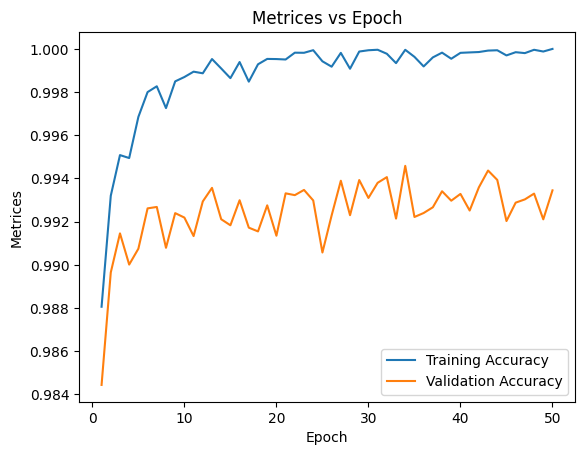

In [106]:
plt.plot(range(1, epoch + 1), train_metrices.accuracy_list, label="Training Accuracy")
plt.plot(range(1, epoch + 1), val_metrices.accuracy_list, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Metrices")
plt.legend()
plt.title("Metrices vs Epoch")

Text(0.5, 1.0, 'Metrices vs Epoch')

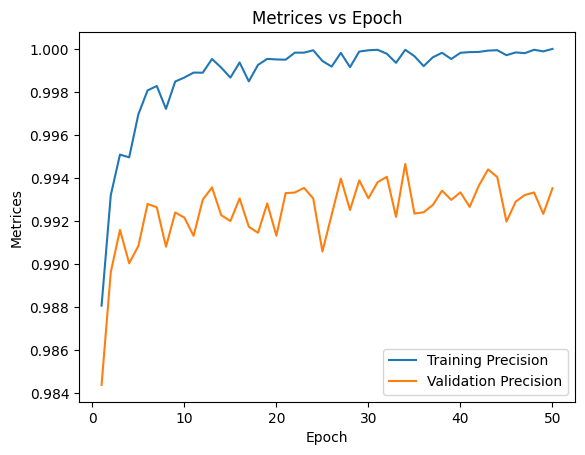

In [107]:
plt.plot(range(1, epoch + 1), train_metrices.precision_list, label="Training Precision")
plt.plot(range(1, epoch + 1), val_metrices.precision_list, label="Validation Precision")
plt.xlabel("Epoch")
plt.ylabel("Metrices")
plt.legend()
plt.title("Metrices vs Epoch")

Text(0.5, 1.0, 'Metrices vs Epoch')

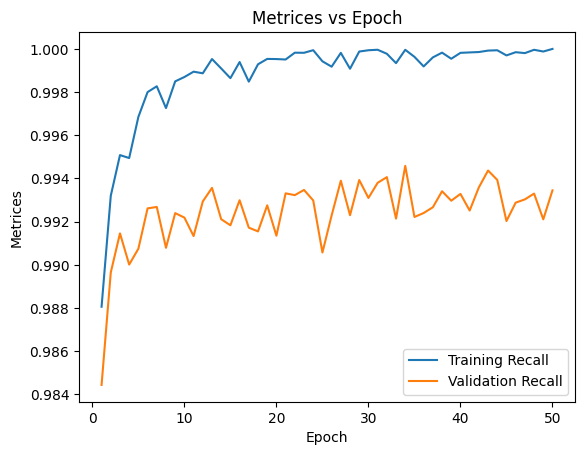

In [108]:
# Here recall is equal to accuracy as in MNIST dataset no of occurances of each class is same
plt.plot(range(1, epoch + 1), train_metrices.recall_list, label="Training Recall")
plt.plot(range(1, epoch + 1), val_metrices.recall_list, label="Validation Recall")
plt.xlabel("Epoch")
plt.ylabel("Metrices")
plt.legend()
plt.title("Metrices vs Epoch")

Text(0.5, 1.0, 'Metrices vs Epoch')

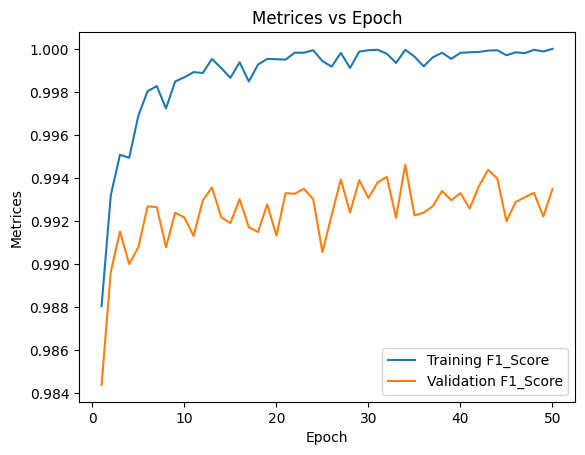

In [109]:
plt.plot(range(1, epoch + 1), train_metrices.f1_score_list, label="Training F1_Score")
plt.plot(range(1, epoch + 1), val_metrices.f1_score_list, label="Validation F1_Score")
plt.xlabel("Epoch")
plt.ylabel("Metrices")
plt.legend()
plt.title("Metrices vs Epoch")

# Final Evaluation on test dataset

In [27]:
test_imgs = torch.tensor(
    np.array(
        [[test_dataset[i][0]] for i in range(len(test_dataset))], dtype=np.float32
    ),
    device=device,
)
test_labels = torch.tensor(
    [test_dataset[i][1] for i in range(len(test_dataset))],
    dtype=torch.int64,
    device=device,
)
test_dataloader = (test_imgs, test_labels)

In [28]:
test_x = test_dataloader[0]
test_y_pred = model(test_x)

dot = make_dot(test_y_pred, params=dict(model.named_parameters()))
dot.format = "png"
dot.render("model")

'model.png'

In [111]:
with torch.no_grad():
    model.eval()
    test_x = test_dataloader[0]
    test_y_pred = model(test_x)
    test_y_true = test_dataloader[1]
    test_metrices = Metrices()
    test_metrices(test_y_pred, test_y_true)
    print("\nFinal Evaluation Metrices:")
    print(
        f"Accuracy: {test_metrices.accuracy:.5f}, Precision: {test_metrices.precision:.5f}, F1_Score: {test_metrices.f1_score:.5f}, Recall: {test_metrices.recall:.5f}"
    )


Final Evaluation Metrices:
Accuracy: 0.99380, Precision: 0.99385, F1_Score: 0.99383, Recall: 0.99380
